In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy.stats import ttest_ind, levene
import math as m
from yfinance import download
from seaborn import heatmap
np.random.seed(0)

start = '2017-01-01'
end = '2019-12-31'

# define exception class for unequal stock histories
def histerror(a,b):
    '''
    Checks if stock histories a and b have the same length
    
    Inputs
    a: stock history (list-like)
    b: stock history (list-like)
  
    Output
    Exception if histories are not equal length
    '''
    
    class HistoryError(Exception):
        pass
    raise HistoryError('Stocks do not have equal history')
    
def checkhist(a,b):
    '''
    Raises exception if stock histories a and b have the same length
    
    Inputs
    a: stock history (list-like)
    b: stock history (list-like)
  
    Output
    Raises the xception if histories are not equal length
    '''
    
    if len(a) != len(b):
        histerror(a,b)

In [2]:
def get_bollinger_bands(values, window=3):
    '''
    Return upper and lower Bollinger Bands.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    band_width(pandas series)
    '''
    #  rolling mean
    rm = values.rolling(window=window).mean()
    rstd = values.rolling(window=window).std()
    
    band_width = 2. * rstd / rm
    return band_width.apply(lambda x: round(x,5))

In [3]:
def get_adj_close_sma_ratio(values, window=3):
    '''
    Return the ratio of adjusted closing value to the simple moving average.
    INPUTS:
    values(pandas series)
    window(int): time period to consider
    OUTPUS:
    ratio(series)
    '''
    rm = values.rolling(window=window).mean()
    ratio = values/rm
    return ratio.apply(lambda x: round(x,5))

In [4]:
def read_stock(stock):
    '''
    Reads stock table from Yahoo Finance
    
    Inputs
    stock: symbol of stock (str)
  
    Output
    Pandas Series of daily stock adj close
    '''
    
    tab = download(stock, start=start, end=end)['Adj Close']
    tab.name = stock.upper()
    return tab

In [5]:
def returns(stock_table):
    '''
    Calculates daily returns from a series of daily stock or portfolio values
    
    Inputs
    stock_table: list of daily stock or portfolio values
  
    Output
    returns: daily multiplier return values (Series)
    '''
    
    returns = stock_table.copy()
    returns.iloc[1:] = returns.iloc[1:]/returns.values[:-1]
    returns.iloc[0] = 1
    return returns

In [6]:
# function to hold every day
def hold(stock_table,money,inc,original_shares):
    '''
    Enacts hold-every-day strategy
    
    Inputs
    stock_table: list of daily stock or portfolio values
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
  
    Output
    results: dictionary holding...
        *one Pandas series each (key/Series names are identical) for*
        final_vals: final daily values of portfolio
        actions: daily actions taken ("BUY" "SELL" "HOLD")
        shares: daily number of shares of stock held
        cash: daily amount of cash held
        
        *additionally*
        qtable: returns None (does not apply to this strategy)
    '''
    
    # calculate daily returns
    ret = returns(stock_table)
    
    # dummy calculations to reset to initialize return calculations
    # what this does is just sets the first entry of the returns Series to total value of stock held originally
    # this way, day 1's return changes from 1 to the original stock value, and the cumprod propogates the daily values accordingly
    ret.iloc[0] = (stock_table.values[0]*original_shares)

    # create actions table
    actions = pd.Series(['HOLD']*len(stock_table),index=stock_table.index)
    
    # create shares table
    shares = pd.Series([original_shares]*len(stock_table),index=stock_table.index)
    
    # create cash table
    cash = pd.Series([money]*len(stock_table),index=stock_table.index)
    
    # calculate daily value of stock held
    final_vals = np.cumprod(ret)
    final_vals.columns = ['value']
    
    # add original cash to this
    final_vals += money
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash,'qtable':None}
    return results

In [7]:
# function to randomly choose action every day
def random_action(stock_table,money,inc,original_shares):
    '''
    Enacts random-daily-action strategy
    
    Inputs
    stock_table: list of daily stock or portfolio values
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
  
    Output
    results: dictionary holding...
        *one Pandas series each (key/Series names are identical) for*
        final_vals: final daily values of portfolio
        actions: daily actions taken ("BUY" "SELL" "HOLD")
        shares: daily number of shares of stock held
        cash: daily amount of cash held
        
        *additionally*
        qtable: returns None (does not apply to this strategy)
    '''
    
    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares

    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]

        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy, buy or hold
        elif cur_shares < inc:
            act = np.random.choice(['BUY','HOLD']) 
            
        # if you can't buy, but you can sell, sell or hold
        elif cur_cash < (cur_price*inc):
            act = np.random.choice(['SELL','HOLD']) 
            
        # otherwise do whatever you want
        else:
            act = np.random.choice(['BUY','SELL','HOLD'])    
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash,'qtable':None}
    return results


In [8]:
#function to choose action based on yesterday's return
def rule_based(stock_table,money,inc, original_shares):
    '''
    Enacts rule-based (buy/sell/hold based on prior day's return) strategy
    
    Inputs
    stock_table: list of daily stock or portfolio values
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
  
    Output
    results: dictionary holding...
        *one Pandas series each (key/Series names are identical) for*
        final_vals: final daily values of portfolio
        actions: daily actions taken ("BUY" "SELL" "HOLD")
        shares: daily number of shares of stock held
        cash: daily amount of cash held
        
        *additionally*
        qtable: returns None (does not apply to this strategy)
    '''

    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares
    
    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]
        
        # calculate last return
        last_ret = ret.values[j]
        
        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy... buy if it makes sense, or hold if it doesn't
        elif cur_shares < inc:
            act = 'BUY' if last_ret > 1 else 'HOLD'
            
        # if you can't buy, but you can sell... sell if it makes sense, or hold if it doesn't
        elif cur_cash < (cur_price*inc):
            act = 'SELL' if last_ret < 1 else 'HOLD'
            
        # otherwise do whatever makes sense
        else:
            if last_ret > 1:
                act = 'BUY'
            elif last_ret < 1:
                act = 'SELL'
            else:
                act = 'HOLD'
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash,'qtable':None}
    return results


In [9]:
# function to choose action based on OLS of returns looking back to trading days t-6 to t-1
def ols(stock_table,money,inc, original_shares):
    '''
    Enacts OLS strategy based on last five days
    
    Inputs
    stock_table: list of daily stock or portfolio values
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
  
    Output
    results: dictionary holding...
        *one Pandas series each (key/Series names are identical) for*
        final_vals: final daily values of portfolio
        actions: daily actions taken ("BUY" "SELL" "HOLD")
        shares: daily number of shares of stock held
        cash: daily amount of cash held
        
        *additionally*
        qtable: returns None (does not apply to this strategy)
    '''
    
    # set lookback window to one week
    lookback = 5

    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares
    
    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]
        
        
        # Perform OLS if past day 3 to define expected return
        if i>2:
            st = ret.values[max(0,j-lookback):j+1] # y
            x = np.arange(len(st)) # x
            exp_ret = sm.OLS(st,add_constant(x)).fit().predict([1,len(st)])
        else:
            exp_ret = 1
   
    
        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            act = 'HOLD'
        
        # if you can't sell, but you can buy... buy if it makes sense, or hold if it doesn't
        elif cur_shares < inc:
            act = 'BUY' if exp_ret > 1 else 'HOLD'
            
        # if you can't buy, but you can sell... sell if it makes sense, or hold if it doesn't
        elif cur_cash < (cur_price*inc):
            act = 'SELL' if exp_ret < 1 else 'HOLD'
            
        # otherwise do whatever makes sense
        else:
            if exp_ret > 1:
                act = 'BUY'
            elif exp_ret < 1:
                act = 'SELL'
            else:
                act = 'HOLD'
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
    
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash,'qtable':None}
    return results


In [10]:
# define and train qlearner - for now this offers dummy output

# define q learner
def trainqlearner():
    ## for now this generates dummy return values
    onetoten = np.array([i for i in range(10)])
    idx = [str(i)+str(j) for i in onetoten for j in onetoten]
    cols = ['BUY','SELL','HOLD']
    Qtable = pd.DataFrame(np.random.randn(len(idx),len(cols)),
                         index=idx,
                         columns=cols)
    tmp = read_stock('JPM')
    tmpbb = get_bollinger_bands(tmp,3)
    tmpsma = get_adj_close_sma_ratio(tmp,3)
    
    BB_quantiles = [tmpbb.quantile(q/10) for q in range(10)]
    SMA_quantiles = [tmpsma.quantile(q/10) for q in range(10)]
    return Qtable, BB_quantiles, SMA_quantiles

# train q learner
ql = trainqlearner()

# define lookback window for SMA and BB
window = 3

[*********************100%***********************]  1 of 1 completed


In [11]:
def qlearner(stock_table,money,inc, original_shares,
             qtable=ql[0], BB_quantiles=ql[1], SMA_quantiles=ql[2],window=window): # defining defaults here prevents need for args to be passed in return_stats function
    '''
    Enacts qlearning
    
    Inputs
    stock_table: list of daily stock or portfolio values
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
    qtable: input qtable (Pandas dataframe, columns are "BUY SELL HOLD", rows are states)
    BB_quantiles: quantiles of Bollinger bands
    SMA_quantiles: quantiles of SMA
    window: lookback window
  
    Output
    results: dictionary holding...
        *one Pandas series each (key/Series names are identical) for*
        final_vals: final daily values of portfolio
        actions: daily actions taken ("BUY" "SELL" "HOLD")
        shares: daily number of shares of stock held
        cash: daily amount of cash held
        
        *additionally*
        qtable: pandas dataframe formatted the same as the input dataframe (will be identical)
    '''
    
    # record original value
    original_val = money + (stock_table.values[0]*original_shares) # initial cash
    
    # generate table of returns
    ret = returns(stock_table)
    
    # create actions table
    actions = ['HOLD']
    
    # create shares table
    shares = stock_table.copy()
    shares.iloc[0] = original_shares
    
    # create cash table
    cash = stock_table.copy()
    cash.iloc[0] = money
    
    # calculate daily portfolio value
    final_vals = stock_table.copy()
    final_vals.iloc[0] = original_val
    
    # iterate through days
    for i in range(1,stock_table.shape[0]):
        j = i-1 # last day
        cur_cash = cash.values[j] # current cash
        cur_shares = shares.values[j] # current shares
        final_vals.iloc[i] = cur_cash + (cur_shares*stock_table.values[i]) # end of day portfolio value
        cur_price = stock_table.values[j]
        
        if i > window: # if we have enough of a lookback window to calculate stats

            # find yesterday's final bollinger band value
            bb = get_bollinger_bands(final_vals.iloc[:i],window).iloc[j]

            # find yesterday's final bollinger band quantile
            try:
                bbq = np.argwhere(np.where(BB_quantiles>bb,1,0))[0][0]
            except IndexError: # if smaller than all quantile values
                #TODO - change this once quantile definition received
                bbq = 0

            # find current SMA value
            sma = get_adj_close_sma_ratio(final_vals.iloc[:i],window).iloc[j]

            # find current SMA quantile
            try:
                smq = np.argwhere(np.where(SMA_quantiles>sma,1,0))[0][0]
            except IndexError:# if smaller than all quantile values
                #TODO - change this once quantile definition received
                smq = 0

            # find state based on these two pieces of information
            state = str(bbq) + str(smq)

            # locate *optimal* action from Q table, which we will then examine to see if it's possible
            cur_act = qtable.loc[state].idxmax()
            
        else: # if we're too early to have a full lookback window
            cur_act = 'HOLD'
    
        # if you can't buy or sell, hold
        if cur_shares < inc and cur_cash < (cur_price*inc):
            cur_act = 'HOLD'
        
        # if you can't sell, but you can buy... buy if it makes sense, or hold if it doesn't
        elif cur_shares < inc:
            act = 'BUY' if cur_act == 'BUY' else 'HOLD'
            
        # if you can't buy, but you can sell... sell if it makes sense, or hold if it doesn't
        elif cur_cash < (cur_price*inc):
            act = 'SELL' if cur_act == 'SELL' else 'HOLD'
            
        # otherwise do whatever makes sense
        else:
            act = cur_act
          
        # take action
        if act == 'HOLD':
            cash.iloc[i] = cash.values[j]
            shares.iloc[i] = shares.values[j]
        if act == 'BUY':
            cash.iloc[i] = cash.values[j] - (inc*cur_price)
            shares.iloc[i] = shares.values[j] + inc   
        if act == 'SELL':
            cash.iloc[i] = cash.values[j] + (inc*cur_price)
            shares.iloc[i] = shares.values[j] - inc
        
        actions += [act]
        
    actions = pd.Series(actions,index=stock_table.index)
   
    results = {'final_vals':final_vals,'actions':actions,'shares':shares,'cash':cash,'qtable':qtable}
    return results

    

In [12]:
# function to return stats and graphs
    
def return_stats(stock='jpm',
                 money=100000,
                 #inc=10,- can read this argument and change code below if doing absolute share-based
                 #original_shares=100, - can read this argument and change code below if doing absolute share-based
                 policies=[hold,random_action,rule_based,ols,qlearner]):
    
    '''
    Enacts every strategy and provides summary statistics and graphs
    
    Inputs
    stock: 
    money: original cash held
    inc: increment of buy/sell permitted
    original_shares: original number of shares held
  
    Output
    None
    
    Provides numerous summary statistics and visualizations
    '''
    
    original_money = money
    
    # generate stock table
    stock_table = read_stock(stock)
    
    # note stock name
    stock_name = stock.upper()
    
    # approximate 50/50 split in money-stock
    original_shares = round(money / 2 / stock_table.values[0])
    
    # recalculate money accordingly
    money -= (stock_table.values[0]*original_shares)
    
    # make share increment about 1% of original share holdings
    inc = m.ceil(original_shares / 100)
    
    # generate results
    results = {policy.__name__:policy(stock_table,
                                      money = money,
                                      inc = inc,
                                      original_shares = original_shares) for policy in policies}
    
    # plot qtables only for qlearner (or any other strategies with Q table)
    for policy in policies:
        if results[policy.__name__]['qtable'] is not None: #don't try to plot Q tables for benchmark strategies
            
            qtab = results[policy.__name__]['qtable']
            
            # marginalize over bollinger bands
            # TODO - determine if this mean was taken correctly
            qtab_bb_tmp = qtab.copy()
            qtab_bb_tmp.index = [s[0] for s in qtab.index] # get first value for each state, indicating BB
            qtab_bb = qtab_bb_tmp.groupby(qtab_bb_tmp.index).mean()
            qtab_bb = qtab_bb.iloc[::-1] # reverse order of rows for visualization purposes - now biggest value will be on top
            qtab_bb.index = np.flip(ql[1]) # define index as bb quantiles, reversing quantile order in kind so biggest value is first
            
            
            # plot BB heatmap
            plt.figure(figsize=(9,7))
            heatmap(qtab_bb)
            plt.title('Bollinger Bands Q-Table',size=16)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=14)
            plt.show()
            
            # marginalize over SMA
            # TODO - determine if this mean was taken correctly
            qtab_sma_tmp = qtab.copy()
            qtab_sma_tmp.index = [s[1] for s in qtab.index] # get second value for each state, indicating SMA
            qtab_sma = qtab_sma_tmp.groupby(qtab_sma_tmp.index).mean()
            qtab_sma = qtab_sma.iloc[::-1]
            qtab_sma.index = np.flip(ql[2])
            
            plt.figure(figsize=(9,7))
            heatmap(qtab_sma)
            plt.title('Simple Moving Average Q-Table',size=16)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=14)
            plt.show()
    
    # plot daily portfolio values
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['final_vals'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Portfolio Value ($)",fontsize=20)  
    plt.title("Daily Portfolio Values For Different Trading Strategies: "+stock.upper(),fontsize=25)
    plt.show()
    
    # plot daily cash values
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['cash'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Cash Held ($)",fontsize=20)  
    plt.title("Daily Cash Held For Different Trading Strategies: "+stock.upper(),fontsize=25)
    plt.show()
    
    # plot daily shares
    plt.figure(figsize=(14,8))
    for policy in policies:
        plt.plot(results[policy.__name__]['shares'],label = policy.__name__)
    plt.legend()
    plt.xlabel("Date",fontsize=20)
    plt.ylabel("Shares Held",fontsize=20)  
    plt.title("Daily Share Holdings For Different Trading Strategies: "+stock_name,fontsize=25)
    plt.show()
    
    # plot daily portfolio values
    for i, policy in enumerate(policies):
        dic = results[policy.__name__]
        del dic['qtable']
        df = pd.DataFrame(dic)
        plt.figure(figsize=(14,8))
        plt.plot([], label="BUY", color="orange", marker='o')  
        plt.plot([], label="SELL", color="black",marker='o')
        plt.plot([], label="HOLD", color="red",marker='o')
        buy_df = df[df.actions == 'BUY']
        sell_df = df[df.actions == 'SELL']
        hold_df = df[df.actions == 'HOLD']
        plt.plot(results[policy.__name__]['final_vals'],label =policy.__name__)
        plt.scatter(buy_df.index, buy_df['final_vals'], color='orange',s=10)
        plt.scatter(sell_df.index, sell_df['final_vals'], color='black',s=10)
        plt.scatter(hold_df.index, hold_df['final_vals'], color='red',s=10)
        plt.xlabel("Date",fontsize=20)
        plt.ylabel("Portfolio Value ($)",fontsize=20)  
        plt.title("Daily Portfolio Values For Trading Strategies of "+ policy.__name__ +" for stock : "+stock.upper(),fontsize=25)
        plt.legend()
        plt.show()
    
    # display percentages
    for policy in policies:
        print('For '+stock_name+',',policy.__name__,'action proportions were:')
        res = results[policy.__name__]['actions'].value_counts()
        res = res / res.sum()
        display(res)
        print('\n')
        print('For '+stock_name+',',policy.__name__,'average return based on action was:')
        res = returns(results[policy.__name__]['final_vals']).groupby(results[policy.__name__]['actions']).mean()
        print(res)
        print('\n')
    
    # calculate final returns
    for policy in policies:
        print('Final porfolio value under',policy.__name__,'strategy for '+stock_name+':',round(results[policy.__name__]['final_vals'].values[-1],0))
    print('\n')   
    
    # calculate final percentage of money invested in stock
    for policy in policies:
        print('Final percentage of money invested in stock under',policy.__name__,\
              'strategy for '+stock_name+':',str(round(100*(1-(results[policy.__name__]['cash'].values[-1]/results[policy.__name__]['final_vals'].values[-1])),1))+'%')
    print('\n') 
    
    # calculate returns
    rets = {policy:returns(results[policy.__name__]['final_vals']) for policy in policies}
    
    # generate risk_free return for sharpe ratio - five-year treasury yield
    rfs = returns(read_stock('^FVX'))
    
    # find common indecies between stock tables and treasury yields 
    rfn = set(stock_table.index).intersection(set(rfs.index))
    
    # now reindex 
    rfr = rfs.loc[rfn]
    rfi = rfr.index
    
    # generate baseline return for information ratio - s&p 500
    bls = returns(read_stock('^GSPC')).values
    
    # print summary stats for daily returns
    for policy in policies:
        nm = policy.__name__
        
        # mean daily return
        print('Mean daily return under',nm,'for',stock_name+':',str(round(np.mean(rets[policy],axis=0),5)))
        
        # standard deviation of daily return
        print('Standard deviation of daily return under',nm,'for',stock_name+':',round(np.std(rets[policy],axis=0),3))
        
        # information ratio of daily return
        checkhist(rets[policy].values,bls)
        pr = np.mean(rets[policy].values)
        br = np.mean(bls)
        te = np.std(rets[policy].values-bls)
        ir = round((pr-br)/(te)*np.sqrt(len(bls)),2)
        print('Information Ratio against S&P 500 under',nm,'strategy for',stock_name+':',ir)
        
        # sharpe ratio of daily return
        dat = rets[policy].loc[rfi].values # need to correct dates to line up with risk free return
        checkhist(dat,rfr)
        rp = np.mean(dat)
        br = np.mean(rfr)
        sd = np.std(rfr-dat)
        sr = round((rp-br)/(sd)*np.sqrt(len(rfr)),2)
        print('Sharpe Ratio against five-year treasury yield under',nm,'strategy for',stock_name+':',sr)
        print('Note: only used dates when five-year treasury yields were available in calculating RFR for Sharpe Ratio')
        print('\n')
    
    for policy1 in policies:
        p1 = rets[policy1].loc[rfi].values # filter to dates with five-year treasury yields available
        n1 = policy1.__name__
        
        # independent samples t-test vs. risk-free return
        checkhist(p1,rfr)
        t = ttest_ind(p1,rfr,equal_var=True)
        gr = t[0] > 0
        n2 = 'rfr'
        p = round(t[1],3)/2 # make one-sided
        if gr:
            print('T-test for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
        else:
            print('T-test for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))
        
        # levene test vs. risk-free return
        l = levene(rets[policy1].values,bls)
        p = round(l[1],3)
        gr = np.std(rets[policy1].values) > np.std(bls)
        n2 = 'bls'
        if gr:
            print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n1,'showing more volatility')
        else:
            print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n2,'showing more volatility')
        print('\n')
        
        for policy2 in policies:
            if policy1 != policy2: #and hash(policy1) <= hash(policy2) - not necessary
                p1 = rets[policy1].values # no longer need to filter to dates with five-year treasury yields available
                p2 = rets[policy2].values
                checkhist(p1,p2)
                n2 = policy2.__name__
                            
                # independent samples t-test
                t = ttest_ind(p1,p2,equal_var=True)
                gr = t[0] > 0
                p = round(t[1],3)/2 # make one-sided
                if gr:
                    print('T-test for difference of mean returns in',n1,'and',n2,'finds',n1,'>',n2,'with p-value',round(p,3))
                else:
                    print('T-test for difference of mean returns in',n2,'and',n1,'finds',n2,'>',n1,'with p-value',round(p,3))
         
                # levene test
                l = levene(p1,p2)
                p = round(l[1],5)
                gr = np.std(p1) > np.std(p2)
                if gr:
                    print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n1,'showing more volatility')
                else:
                    print('Levene test for difference of variances (volatility) in',n1,'and',n2,'finds p-value of',round(p,3),'with',n2,'showing more volatility')
                print('\n')
            print('\n')
            
    # TODO: add any additional desired visualizations 

[*********************100%***********************]  1 of 1 completed


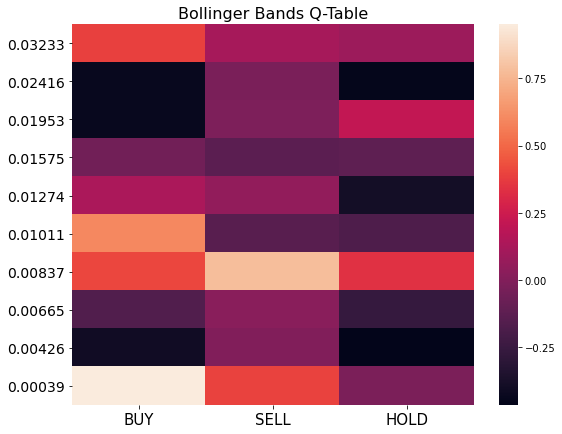

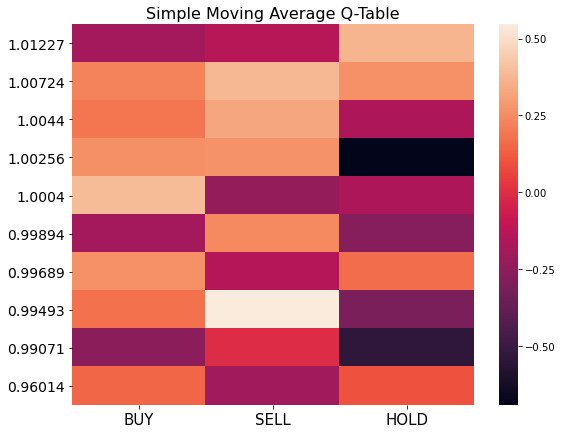

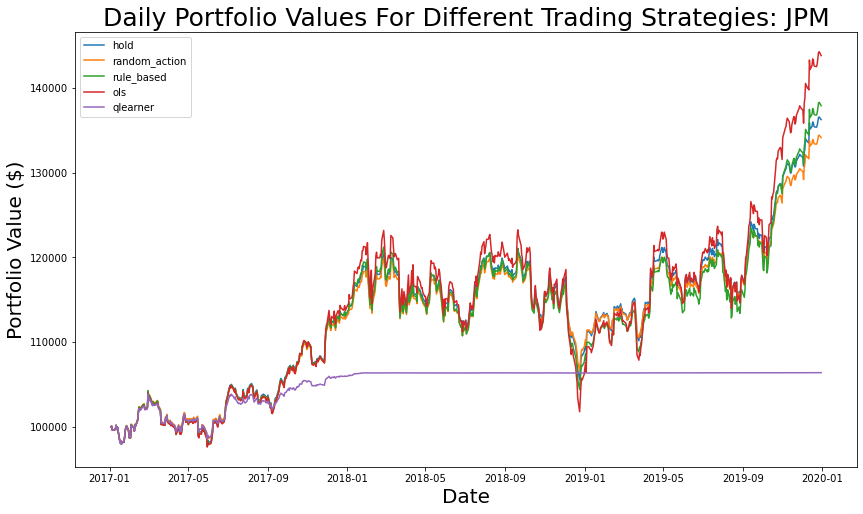

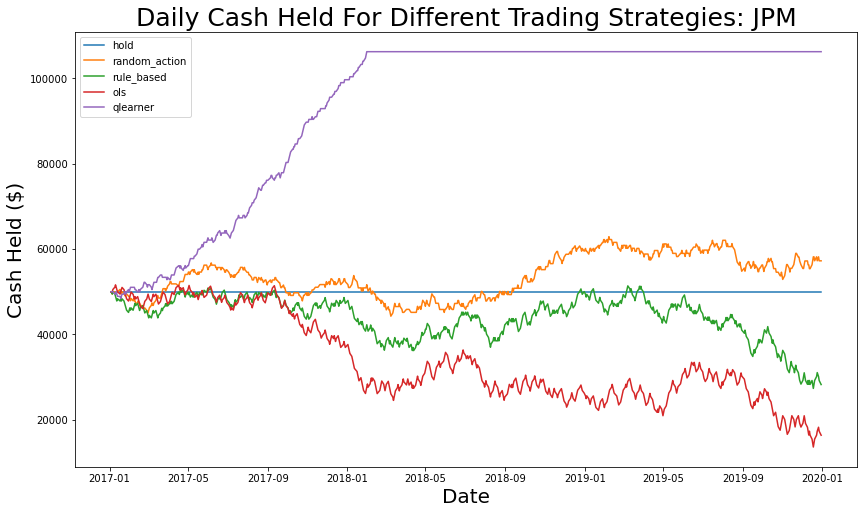

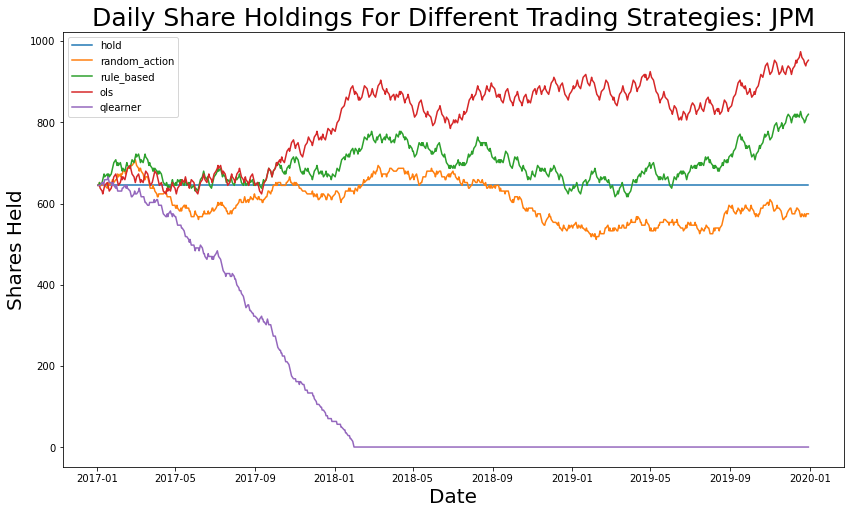

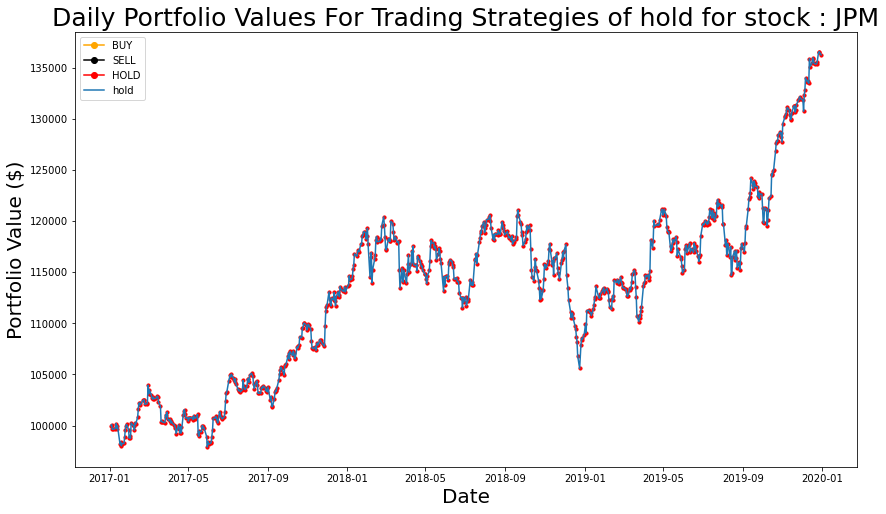

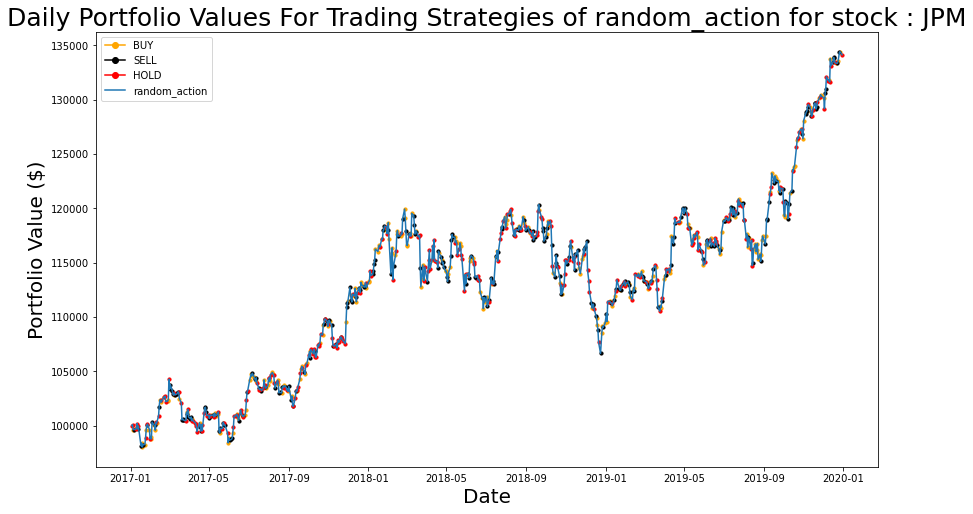

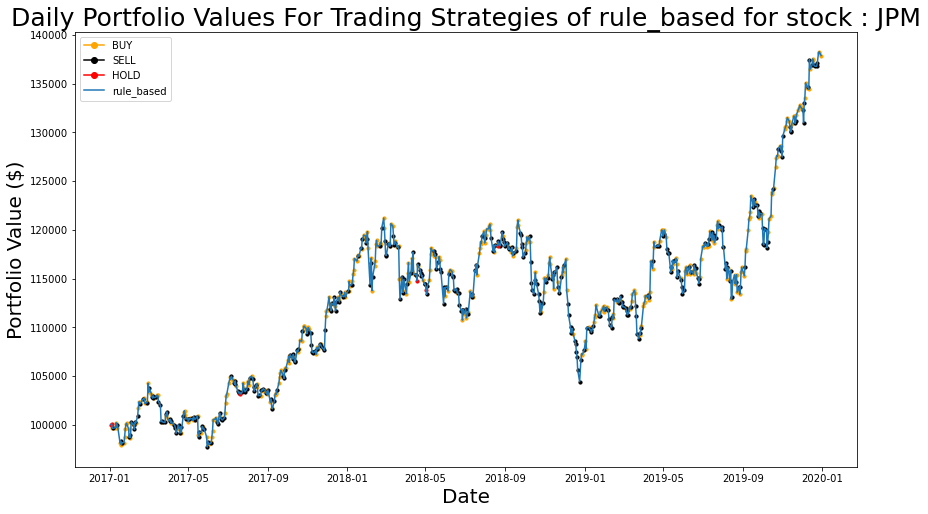

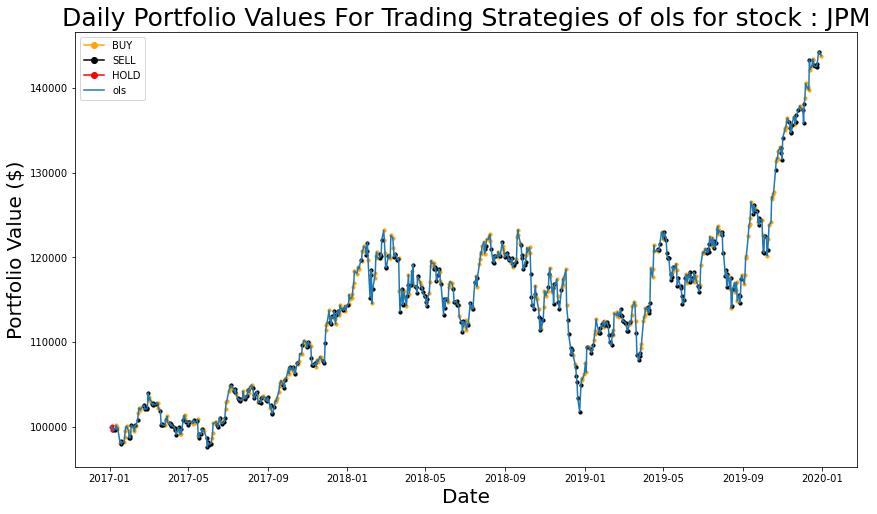

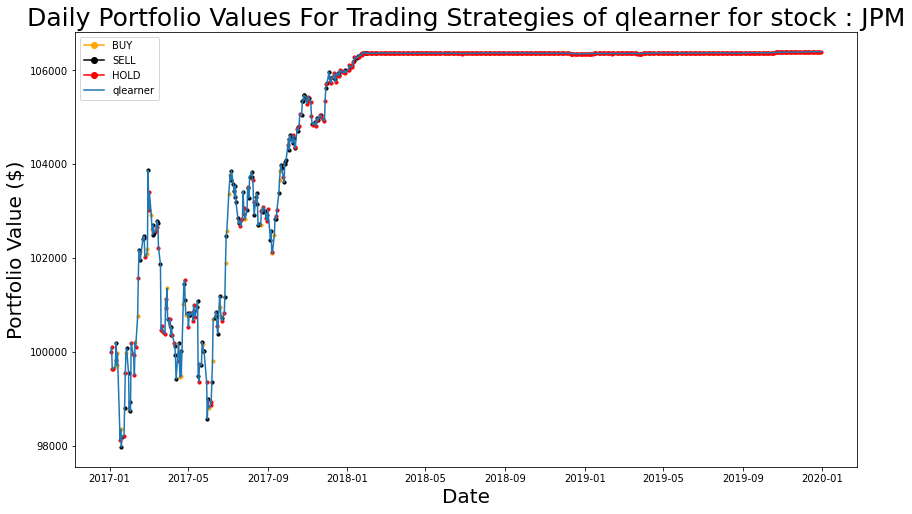

For JPM, hold action proportions were:


HOLD    1.0
dtype: float64



For JPM, hold average return based on action was:
HOLD    1.000434
Name: JPM, dtype: float64


For JPM, random_action action proportions were:


SELL    0.341301
HOLD    0.330677
BUY     0.328021
dtype: float64



For JPM, random_action average return based on action was:
BUY     1.001215
HOLD    1.000213
SELL    0.999828
Name: JPM, dtype: float64


For JPM, rule_based action proportions were:


BUY     0.512616
SELL    0.479416
HOLD    0.007968
dtype: float64



For JPM, rule_based average return based on action was:
BUY     1.000487
HOLD    0.997956
SELL    1.000460
Name: JPM, dtype: float64


For JPM, ols action proportions were:


BUY     0.527224
SELL    0.468792
HOLD    0.003984
dtype: float64



For JPM, ols average return based on action was:
BUY     1.000502
HOLD    0.998771
SELL    1.000555
Name: JPM, dtype: float64


For JPM, qlearner action proportions were:


HOLD    0.776892
SELL    0.172643
BUY     0.050465
dtype: float64



For JPM, qlearner average return based on action was:
BUY     1.001143
HOLD    0.999964
SELL    1.000318
Name: JPM, dtype: float64


Final porfolio value under hold strategy for JPM: 136251.0
Final porfolio value under random_action strategy for JPM: 134140.0
Final porfolio value under rule_based strategy for JPM: 137895.0
Final porfolio value under ols strategy for JPM: 143802.0
Final porfolio value under qlearner strategy for JPM: 106399.0


Final percentage of money invested in stock under hold strategy for JPM: 63.3%
Final percentage of money invested in stock under random_action strategy for JPM: 57.3%
Final percentage of money invested in stock under rule_based strategy for JPM: 79.6%
Final percentage of money invested in stock under ols strategy for JPM: 88.7%
Final percentage of money invested in stock under qlearner strategy for JPM: 0.1%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete




T-test for difference of mean returns in ols and qlearner finds ols > qlearner with p-value 0.091
Levene test for difference of variances (volatility) in qlearner and ols finds p-value of 0.0 with ols showing more volatility








In [13]:
stocks = ['jpm']
for stock in stocks:
    return_stats(stock)